In [1]:
from awgcsl.envs import *
from awgcsl.envs.multi_world_wrapper import PointGoalWrapper, SawyerGoalWrapper, ReacherGoalWrapper
import awgcsl.envs
import awgcsl
import gym
from gym import wrappers
from gym.envs.registration import register
# from argparse import ArgumentParser
# def parse_args():
#     parser = ArgumentParser(description='train args')
#     parser.add_argument('-en','--env_name', type=str, default=None)
#     parser.add_argument('-r','--repeat',type=int,default=None)
#     return parser.parse_args()


def register_envs():
    register(
        id='SawyerReachXYZEnv-v1',
        entry_point='awgcsl.envs.sawyer_reach:SawyerReachXYZEnv',
        tags={
            'git-commit-hash': '2d95c75',
            'author': 'murtaza'
        },
        kwargs={
            'hide_goal_markers': True,
            'norm_order': 2,
        },
    )
    register(
        id='Point2DLargeEnv-v1',
        entry_point='awgcsl.envs.point2d:Point2DEnv',
        tags={
            'git-commit-hash': '4efe2be',
            'author': 'Vitchyr'
        },
        kwargs={
            'images_are_rgb': True,
            'target_radius': 1,
            'ball_radius': 0.5,
            'boundary_dist':5,
            'render_onscreen': False,
            'show_goal': True,
            'render_size':512,
            'get_image_base_render_size': (48, 48),
            'bg_color': 'white',
        },
    )
    register(
        id='Point2D-FourRoom-v1',
        entry_point='awgcsl.envs.point2d:Point2DWallEnv',
        kwargs={
            'action_scale': 1,
            'wall_shape': 'four-room-v1', 
            'wall_thickness': 0.30,
            'target_radius':1,
            'ball_radius':0.5,
            'boundary_dist':5,
            'render_size': 512,
            'wall_color': 'darkgray',
            'bg_color': 'white',
            'images_are_rgb': True,
            'render_onscreen': False,
            'show_goal': True,
            'get_image_base_render_size': (48, 48),
        },
    )
    # register gcsl envs
    register(
        id='SawyerDoor-v0',
        entry_point='awgcsl.envs.sawyer_door:SawyerDoorGoalEnv',
    )
register_envs()
"""
ref: Schulman, John, et al. "Proximal policy optimization algorithms." arXiv preprint arXiv:1707.06347 (2017).
ref: https://github.com/Jiankai-Sun/Proximal-Policy-Optimization-in-Pytorch/blob/master/ppo.py
ref: https://github.com/openai/baselines/tree/master/baselines/ppo2
"""
import torch.nn.functional as F
import random
from copy import deepcopy
from collections import deque
from IPython.display import clear_output
import gym
import torch
import torch.nn as nn
import torch.optim as opt
from torch import Tensor
from torch.autograd import Variable
from collections import namedtuple
from itertools import count
import matplotlib
import matplotlib.pyplot as plt
from os.path import join as joindir
from os import makedirs as mkdir
import pandas as pd
import numpy as np
import argparse
import datetime
import math
from IPython import embed

for env_id in [args.env_name]:
    env = gym.make(env_id)

    if env_id.startswith('Fetch'):
        env._max_episode_steps = 50
    elif env_id.startswith('Sawyer'):
        from awgcsl.envs.multi_world_wrapper import SawyerGoalWrapper
        env = SawyerGoalWrapper(env)
        if not hasattr(env, '_max_episode_steps'):
            env = gym.wrappers.TimeLimit(env, max_episode_steps=50)
    elif env_id.startswith('Point2D'):
        from awgcsl.envs.multi_world_wrapper import PointGoalWrapper
        env = gym.wrappers.TimeLimit(env, max_episode_steps=50)
        env = PointGoalWrapper(env)
    elif env_id.startswith('Reacher'):
        from awgcsl.envs.multi_world_wrapper import ReacherGoalWrapper
        env._max_episode_steps = 50
        env = ReacherGoalWrapper(env)
    else:
        env = gym.wrappers.TimeLimit(env, max_episode_steps=50)

    class RewardWrapper(gym.RewardWrapper):
        def __init__(self, env):
            super().__init__(env)

        def reward(self, rew):
            if rew != 0 and rew!= -1:
                print(rew)
            assert rew == 0 or rew == -1, 'input reward should be -1/0'
            return rew + 1

    env = RewardWrapper(env)
    

    LR_PPO = 5e-4
    LR_HID = 0.0
    FUTURE_P = 0.0

    for repeat in range(args.repeat, args.repeat+1):
        class args(object):
            seed = 1234 + repeat
            num_episode = 400 if ('SawyerDoor' in env_id or 'Reacher' in env_id) else 50
            batch_size = 250
            max_step_per_round = 50
            gamma = 0.98
            lamda = 0.97
            log_num_episode = 1
            num_epoch = 10
            minibatch_size = 25
            clip = 0.2
            loss_coeff_value = 0.5
            loss_coeff_entropy = 0.01

            lr_ppo = LR_PPO
            lr_hid = LR_HID
            future_p = FUTURE_P # param of HER
            
        

            num_parallel_run = 1
            # tricks
            schedule_adam = 'linear'
            schedule_clip = 'linear'
            layer_norm = True
            state_norm = True
            advantage_norm = True
            lossvalue_norm = True
            replay_buffer_size_IER = 50000 

        rwds = []
        Succ_recorder = []
        global losses
        Horizon_list = [1]
        losses = [[]]

        Transition = namedtuple('Transition', ('state', 'value', 'action', 'logproba', 'mask', 'next_state', 'reward'))
        EPS = 1e-6
        RESULT_DIR = 'Result_PPO'
        mkdir(RESULT_DIR, exist_ok=True)


        class RunningStat(object):
            def __init__(self, shape):
                self._n = 0
                self._M = np.zeros(shape)
                self._S = np.zeros(shape)

            def push(self, x):
                x = np.asarray(x)
                assert x.shape == self._M.shape
                self._n += 1
                if self._n == 1:
                    self._M[...] = x
                else:
                    oldM = self._M.copy()
                    self._M[...] = oldM + (x - oldM) / self._n
                    self._S[...] = self._S + (x - oldM) * (x - self._M)

            @property
            def n(self):
                return self._n

            @property
            def mean(self):
                return self._M

            @property
            def var(self):
                return self._S / (self._n - 1) if self._n > 1 else np.square(self._M)

            @property
            def std(self):
                return np.sqrt(self.var)

            @property
            def shape(self):
                return self._M.shape


        class ZFilter:
            """
            y = (x-mean)/std
            using running estimates of mean,std
            """

            def __init__(self, shape, demean=True, destd=True, clip=10.0):
                self.demean = demean
                self.destd = destd
                self.clip = clip

                self.rs = RunningStat(shape)

            def __call__(self, x, update=True):
                if update: self.rs.push(x)
                if self.demean:
                    x = x - self.rs.mean
                if self.destd:
                    x = x / (self.rs.std + 1e-8)
                if self.clip:
                    x = np.clip(x, -self.clip, self.clip)
                return x

            def output_shape(self, input_space):
                return input_space.shape


        class ActorCritic(nn.Module):
            def __init__(self, num_inputs, num_outputs, layer_norm=True):
                super(ActorCritic, self).__init__()

                self.actor_fc1 = nn.Linear(num_inputs, 256)
                self.actor_fc2 = nn.Linear(256, 256)
                self.actor_fc3 = nn.Linear(256, num_outputs)
                self.actor_logstd = nn.Parameter(torch.zeros(1, num_outputs))

                self.critic_fc1 = nn.Linear(num_inputs, 256)
                self.critic_fc2 = nn.Linear(256, 256)
                self.critic_fc3 = nn.Linear(256, 1)

                if layer_norm:
                    self.layer_norm(self.actor_fc1, std=1.0)
                    self.layer_norm(self.actor_fc2, std=1.0)
                    self.layer_norm(self.actor_fc3, std=0.01)

                    self.layer_norm(self.critic_fc1, std=1.0)
                    self.layer_norm(self.critic_fc2, std=1.0)
                    self.layer_norm(self.critic_fc3, std=1.0)

            @staticmethod
            def layer_norm(layer, std=1.0, bias_const=0.0):
                torch.nn.init.orthogonal_(layer.weight, std)
                torch.nn.init.constant_(layer.bias, bias_const)

            def forward(self, states):
                action_mean, action_logstd = self._forward_actor(states)
                critic_value = self._forward_critic(states)
                return action_mean, action_logstd, critic_value

            def _forward_actor(self, states):
                x = torch.tanh(self.actor_fc1(states))
                x = torch.tanh(self.actor_fc2(x))
                action_mean = self.actor_fc3(x)
                action_logstd = self.actor_logstd.expand_as(action_mean)
                return action_mean, action_logstd

            def _forward_critic(self, states):
                x = torch.tanh(self.critic_fc1(states))
                x = torch.tanh(self.critic_fc2(x))
                critic_value = self.critic_fc3(x)
                return critic_value

            def select_action(self, action_mean, action_logstd, return_logproba=True):
                action_std = torch.exp(action_logstd)
                action = torch.normal(action_mean, action_std)
                if return_logproba:
                    logproba = self._normal_logproba(action, action_mean, action_logstd, action_std)
                return action, logproba

            @staticmethod
            def _normal_logproba(x, mean, logstd, std=None):
                if std is None:
                    std = torch.exp(logstd)

                std_sq = std.pow(2)
                logproba = - 0.5 * math.log(2 * math.pi) - logstd - (x - mean).pow(2) / (2 * std_sq)
                return logproba.sum(1)

            def get_logproba(self, states, actions):
                action_mean, action_logstd = self._forward_actor(states)
                logproba = self._normal_logproba(actions, action_mean, action_logstd)
                return logproba


        class Memory(object):
            def __init__(self):
                self.memory = []

            def push(self, *args):
                self.memory.append(Transition(*args))

            def sample(self):
                return Transition(*zip(*self.memory))

            def __len__(self):
                return len(self.memory)
        class ReplayBuffer_imitation(object):
            def __init__(self, capacity):
                self.buffer = {'1step':deque(maxlen=capacity)}
                self.capacity = capacity
            def push(self, state, action, step_num):
                try:
                    self.buffer[step_num]
                except:
                    self.buffer[step_num] = deque(maxlen=self.capacity)
                self.buffer[step_num].append((state, action))


            def sample(self, batch_size,step_num):
                state, action= zip(*random.sample(self.buffer[step_num], batch_size))
                return np.stack(state), action

            def lenth(self,step_num):
                try:
                    self.buffer[step_num]
                except:
                    return 0
                return len(self.buffer[step_num])

            def __len__(self,step_num):
                try:
                    self.buffer[step_num]
                except:
                    return 0
                return len(self.buffer[step_num])


        num_inputs = env.observation_space.spaces['observation'].shape[0] + env.observation_space.spaces['desired_goal'].shape[0] + env.observation_space.spaces['achieved_goal'].shape[0]# extended state
        num_actions = env.action_space.shape[0]
        network = ActorCritic(num_inputs, num_actions, layer_norm=args.layer_norm)
        model_imitation = network

        Horizon_list = [1]

        def ppo(args):
            num_inputs = env.observation_space.spaces['observation'].shape[0] + env.observation_space.spaces['desired_goal'].shape[0] + env.observation_space.spaces['achieved_goal'].shape[0]# extended state
            num_actions = env.action_space.shape[0]

            env.seed(args.seed)
            torch.manual_seed(args.seed)

            optimizer = opt.Adam(network.parameters(), lr=args.lr_ppo)
            optimizer_imitation = opt.Adam(model_imitation.parameters(),lr = args.lr_hid )


            running_state = ZFilter((num_inputs,), clip=5.0)


            reward_record = []
            global_steps = 0

            lr_now = args.lr_ppo
            clip_now = args.clip
            ier_buffer = ReplayBuffer_imitation(args.replay_buffer_size_IER)
            for i_episode in range(args.num_episode):
                memory = Memory()
                num_steps = 0
                reward_list = []
                len_list = []
                Succ_num = 0

                game_num = 0
                succ_game = 0
                while num_steps < args.batch_size:
                    state = env.reset()
                    game_num +=1
                    state = np.concatenate((state['observation'],state['desired_goal'],state['achieved_goal'])) # state_extended

                    if args.state_norm:
                        state = running_state(state)
                    reward_sum = 0
                    episode = []
                    env_list = []
                    Succ_in_env = 0
                    for t in range(args.max_step_per_round):
                        action_mean, action_logstd, value = network(Tensor(state).unsqueeze(0))
                        action, logproba = network.select_action(action_mean, action_logstd)

                        action = action.data.numpy()[0]
                        logproba = logproba.data.numpy()[0]
                        #print('action:',action)
                        if np.sum(np.isnan(action))>0:
                            embed()
                        next_state, reward, done, _ = env.step(action)
                        if _['is_success'] !=0:
                            Succ_in_env = 1
                            Succ_num+=1
                        next_state = np.concatenate((next_state['observation'],next_state['desired_goal'],next_state['achieved_goal']))

                        reward_sum += reward
                        if args.state_norm:
                            next_state = running_state(next_state)
                        mask = 0 if done else 1
                        episode.append((state, value, action, logproba, mask, next_state, reward))
                        memory.push(state, value, action, logproba, mask, next_state, reward)
                        if done:
                            break

                        state = next_state
                    succ_game += Succ_in_env

                    #for ind,(state, value, action, logproba, mask, next_state, reward) in enumerate(episode):
                        



                    num_steps += (t + 1)
                    global_steps += (t + 1)
                    reward_list.append(reward_sum)
                    len_list.append(t + 1)
                    Winrate = 1.0*succ_game/game_num
                    Succ_recorder.append(Winrate)

                reward_record.append({
                    'episode': i_episode, 
                    'steps': global_steps, 
                    'meanepreward': np.mean(reward_list), 
                    'meaneplen': np.mean(len_list)})

                rwds.extend(reward_list)
                batch = memory.sample()
                batch_size = len(memory)

                SR = 1.0*Succ_num/num_steps

                # step2: extract variables from trajectories
                rewards = Tensor(batch.reward)
                values = Tensor(batch.value)
                masks = Tensor(batch.mask)
                actions = Tensor(batch.action)
                states = Tensor(batch.state)
                oldlogproba = Tensor(batch.logproba)

                returns = Tensor(batch_size)
                deltas = Tensor(batch_size)
                advantages = Tensor(batch_size)

                prev_return = 0
                prev_value = 0
                prev_advantage = 0
                for i in reversed(range(batch_size)):
                    returns[i] = rewards[i] + args.gamma * prev_return * masks[i]
                    deltas[i] = rewards[i] + args.gamma * prev_value * masks[i] - values[i]
                    # ref: https://arxiv.org/pdf/1506.02438.pdf (generalization advantage estimate)
                    advantages[i] = deltas[i] + args.gamma * args.lamda * prev_advantage * masks[i]

                    prev_return = returns[i]
                    prev_value = values[i]
                    prev_advantage = advantages[i]
                if args.advantage_norm:
                    advantages = (advantages - advantages.mean()) / (advantages.std() + EPS)

                for i_epoch in range(int(args.num_epoch * batch_size / args.minibatch_size)):
                    # sample from current batch
                    minibatch_ind = np.random.choice(batch_size, args.minibatch_size, replace=False)
                    minibatch_states = states[minibatch_ind]
                    minibatch_actions = actions[minibatch_ind]
                    minibatch_oldlogproba = oldlogproba[minibatch_ind]
                    minibatch_newlogproba = network.get_logproba(minibatch_states, minibatch_actions)
                    minibatch_advantages = advantages[minibatch_ind]
                    minibatch_returns = returns[minibatch_ind]
                    minibatch_newvalues = network._forward_critic(minibatch_states).flatten()

                    ratio =  torch.exp(minibatch_newlogproba - minibatch_oldlogproba)
                    surr1 = ratio * minibatch_advantages
                    surr2 = ratio.clamp(1 - clip_now, 1 + clip_now) * minibatch_advantages
                    loss_surr = - torch.mean(torch.min(surr1, surr2))

                    if args.lossvalue_norm:
                        minibatch_return_6std = 6 * minibatch_returns.std() + EPS
                        loss_value = torch.mean((minibatch_newvalues - minibatch_returns).pow(2)) / minibatch_return_6std
                    else:
                        loss_value = torch.mean((minibatch_newvalues - minibatch_returns).pow(2))

                    loss_entropy = torch.mean(torch.exp(minibatch_newlogproba) * minibatch_newlogproba)

                    total_loss = loss_surr + args.loss_coeff_value * loss_value + args.loss_coeff_entropy * loss_entropy
                    optimizer.zero_grad()
                    total_loss.backward()
                    optimizer.step()


                if args.schedule_clip == 'linear':
                    ep_ratio = 1 - (i_episode / args.num_episode)
                    clip_now = args.clip * ep_ratio

                if args.schedule_adam == 'linear':
                    ep_ratio = 1 - (i_episode / args.num_episode)
                    lr_now = args.lr_ppo * ep_ratio
                    for g in optimizer.param_groups:
                        g['lr'] = lr_now

                if i_episode % args.log_num_episode == 0:
                    print('Finished episode: {} Reward: {:.4f} Stay Rate{:.4f} SuccessRate{:.4f}' \
                        .format(i_episode, reward_record[-1]['meanepreward'],SR,Winrate))
                    print('-----------------')

            return reward_record

        def test(args):
            record_dfs = []
            for i in range(args.num_parallel_run):
                args.seed += 1
                reward_record = pd.DataFrame(ppo(args))
                reward_record['#parallel_run'] = i
                record_dfs.append(reward_record)
            record_dfs = pd.concat(record_dfs, axis=0)
            record_dfs.to_csv(joindir(RESULT_DIR, 'ppo-record-env{}_repeat{}.csv'.format(env_id, repeat)))


        test(args)
        rwds_HER_HID= deepcopy(rwds)
        Succ_recorder_HER_HID= deepcopy(Succ_recorder)
        np.save('Result_PPO/method_{}_env{}_repeat{}'.format(METHOD,env_id,repeat),(rwds_HER_HID,Succ_recorder_HER_HID))

# Load Logs

In [84]:
import numpy as np

In [85]:
data[0]

"/home/hsun/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: \x1bWARN: Box bound precision lowered by casting to float32\x1b\n  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))\nFinished episode: 0 Reward: 0.0000 Stay Rate0.0000 SuccessRate0.0000\n"

In [86]:
import os
fl = os.listdir('logs')

In [87]:
fl

['pointlarge3.txt',
 'fetchreach4.txt',
 'reacher1.txt',
 'pointlarge1.txt',
 'point2d1.txt',
 'sawyer5.txt',
 'pointlarge5.txt',
 'sawyerxyz4.txt',
 'fetchreach2.txt',
 'reacher4.txt',
 'sawyerxyz1.txt',
 'sawyer1.txt',
 'sawyer4.txt',
 'sawyerxyz5.txt',
 'reacher2.txt',
 'pointlarge2.txt',
 'fetchreach5.txt',
 'point2d2.txt',
 'fetchreach1.txt',
 'fetchreach3.txt',
 'sawyer2.txt',
 'reacher5.txt',
 'reacher3.txt',
 'sawyerxyz2.txt',
 'point2d5.txt',
 'pointlarge4.txt',
 'sawyer3.txt',
 'point2d4.txt',
 'point2d3.txt',
 'sawyerxyz3.txt']

In [121]:
data[episode].split('result: (')[1].split(')')[0].split(',')

['2.29', ' 1.4779032258609022', ' 2.29', ' 0.57']

In [139]:
result = {}
for file_name in fl:
    with open(f"logs/{file_name}", "r") as f:
        data = f.read().split('-----------------')
    result[file_name] = []
    for episode in range(len(data)-1):
        
        ep = int(data[episode].split('episode:')[1].split('Reward:')[0])
        rew = float(data[episode].split('episode:')[1].split('Reward:')[1].split('Stay Rate')[0].split('Return')[0])
        ret = float(data[episode].split('episode:')[1].split('Reward:')[1].split('Stay Rate')[0].split('Return')[1])
        st_r = float(data[episode].split('Return')[1].split('Stay Rate')[1].split('SuccessRate')[0])
        su_r = float(data[episode].split('Return')[1].split('Stay Rate')[1].split('SuccessRate')[1].split('\n')[0])
        
        eval_rew = float(data[episode].split('result: (')[1].split(')')[0].split(',')[0])
        eval_ret = float(data[episode].split('result: (')[1].split(')')[0].split(',')[1])
        eval_succ = float(data[episode].split('result: (')[1].split(')')[0].split(',')[2])
        eval_stay = float(data[episode].split('result: (')[1].split(')')[0].split(',')[3])
        
        print('episode:',ep)
        print('reward',rew)
        print('stay rate',st_r)
        print('success rate',su_r)
        result[file_name].append((ep, rew, ret, st_r, su_r, eval_rew, eval_ret, eval_stay, eval_succ))

episode: 0
reward 0.8
stay rate 0.016
success rate 0.2
episode: 1
reward 1.6
stay rate 0.032
success rate 0.4
episode: 2
reward 1.0
stay rate 0.02
success rate 0.2
episode: 3
reward 0.2
stay rate 0.004
success rate 0.2
episode: 4
reward 0.4
stay rate 0.008
success rate 0.4
episode: 5
reward 2.2
stay rate 0.044
success rate 0.6
episode: 6
reward 0.2
stay rate 0.004
success rate 0.2
episode: 7
reward 3.2
stay rate 0.064
success rate 0.6
episode: 8
reward 7.6
stay rate 0.152
success rate 0.8
episode: 9
reward 3.6
stay rate 0.072
success rate 0.6
episode: 10
reward 4.0
stay rate 0.08
success rate 0.6
episode: 11
reward 5.8
stay rate 0.116
success rate 0.8
episode: 12
reward 3.2
stay rate 0.064
success rate 0.8
episode: 13
reward 3.2
stay rate 0.064
success rate 0.8
episode: 14
reward 1.2
stay rate 0.024
success rate 0.4
episode: 15
reward 3.6
stay rate 0.072
success rate 0.6
episode: 16
reward 4.0
stay rate 0.08
success rate 0.6
episode: 17
reward 9.2
stay rate 0.184
success rate 0.8
episo

stay rate 0.08
success rate 0.8
episode: 6
reward 2.4
stay rate 0.048
success rate 0.6
episode: 7
reward 1.0
stay rate 0.02
success rate 0.2
episode: 8
reward 1.2
stay rate 0.024
success rate 0.4
episode: 9
reward 0.2
stay rate 0.004
success rate 0.2
episode: 10
reward 5.8
stay rate 0.116
success rate 1.0
episode: 11
reward 3.0
stay rate 0.06
success rate 0.8
episode: 12
reward 2.8
stay rate 0.056
success rate 0.8
episode: 13
reward 2.0
stay rate 0.04
success rate 0.4
episode: 14
reward 8.0
stay rate 0.16
success rate 1.0
episode: 15
reward 2.0
stay rate 0.04
success rate 0.8
episode: 16
reward 0.0
stay rate 0.0
success rate 0.0
episode: 17
reward 3.4
stay rate 0.068
success rate 0.8
episode: 18
reward 7.0
stay rate 0.14
success rate 1.0
episode: 19
reward 3.8
stay rate 0.076
success rate 1.0
episode: 20
reward 5.2
stay rate 0.104
success rate 0.8
episode: 21
reward 1.8
stay rate 0.036
success rate 0.6
episode: 22
reward 6.2
stay rate 0.124
success rate 1.0
episode: 23
reward 2.2
stay 

success rate 1.0
episode: 163
reward 2.0
stay rate 0.04
success rate 0.8
episode: 164
reward 3.4
stay rate 0.068
success rate 1.0
episode: 165
reward 2.2
stay rate 0.044
success rate 1.0
episode: 166
reward 2.8
stay rate 0.056
success rate 0.8
episode: 167
reward 7.4
stay rate 0.148
success rate 1.0
episode: 168
reward 4.4
stay rate 0.088
success rate 1.0
episode: 169
reward 1.0
stay rate 0.02
success rate 1.0
episode: 170
reward 1.6
stay rate 0.032
success rate 1.0
episode: 171
reward 3.2
stay rate 0.064
success rate 0.8
episode: 172
reward 17.8
stay rate 0.356
success rate 0.8
episode: 173
reward 4.6
stay rate 0.092
success rate 0.8
episode: 174
reward 1.8
stay rate 0.036
success rate 0.6
episode: 175
reward 4.4
stay rate 0.088
success rate 0.8
episode: 176
reward 2.8
stay rate 0.056
success rate 0.8
episode: 177
reward 0.6
stay rate 0.012
success rate 0.6
episode: 178
reward 5.4
stay rate 0.108
success rate 0.6
episode: 179
reward 3.2
stay rate 0.064
success rate 0.8
episode: 180
re

reward 6.0
stay rate 0.12
success rate 1.0
episode: 356
reward 1.4
stay rate 0.028
success rate 0.6
episode: 357
reward 3.8
stay rate 0.076
success rate 0.6
episode: 358
reward 7.0
stay rate 0.14
success rate 0.8
episode: 359
reward 3.2
stay rate 0.064
success rate 0.8
episode: 360
reward 10.8
stay rate 0.216
success rate 0.6
episode: 361
reward 0.8
stay rate 0.016
success rate 0.8
episode: 362
reward 6.8
stay rate 0.136
success rate 1.0
episode: 363
reward 7.8
stay rate 0.156
success rate 0.8
episode: 364
reward 1.2
stay rate 0.024
success rate 1.0
episode: 365
reward 8.2
stay rate 0.164
success rate 0.6
episode: 366
reward 0.6
stay rate 0.012
success rate 0.4
episode: 367
reward 3.0
stay rate 0.06
success rate 0.8
episode: 368
reward 1.0
stay rate 0.02
success rate 0.8
episode: 369
reward 4.0
stay rate 0.08
success rate 0.6
episode: 370
reward 2.4
stay rate 0.048
success rate 0.6
episode: 371
reward 1.4
stay rate 0.028
success rate 0.6
episode: 372
reward 9.0
stay rate 0.18
success r

stay rate 0.132
success rate 0.8
episode: 143
reward 4.0
stay rate 0.08
success rate 0.8
episode: 144
reward 3.4
stay rate 0.068
success rate 0.8
episode: 145
reward 4.6
stay rate 0.092
success rate 0.8
episode: 146
reward 4.6
stay rate 0.092
success rate 0.6
episode: 147
reward 5.6
stay rate 0.112
success rate 0.6
episode: 148
reward 4.4
stay rate 0.088
success rate 1.0
episode: 149
reward 3.8
stay rate 0.076
success rate 0.6
episode: 150
reward 3.6
stay rate 0.072
success rate 1.0
episode: 151
reward 12.2
stay rate 0.244
success rate 1.0
episode: 152
reward 5.6
stay rate 0.112
success rate 1.0
episode: 153
reward 3.0
stay rate 0.06
success rate 0.8
episode: 154
reward 6.6
stay rate 0.132
success rate 0.8
episode: 155
reward 8.4
stay rate 0.168
success rate 0.6
episode: 156
reward 3.0
stay rate 0.06
success rate 1.0
episode: 157
reward 3.6
stay rate 0.072
success rate 1.0
episode: 158
reward 2.2
stay rate 0.044
success rate 0.6
episode: 159
reward 1.2
stay rate 0.024
success rate 0.6


stay rate 0.116
success rate 1.0
episode: 393
reward 1.8
stay rate 0.036
success rate 0.6
episode: 394
reward 6.2
stay rate 0.124
success rate 1.0
episode: 395
reward 5.0
stay rate 0.1
success rate 1.0
episode: 396
reward 5.8
stay rate 0.116
success rate 1.0
episode: 397
reward 3.0
stay rate 0.06
success rate 1.0
episode: 398
reward 3.6
stay rate 0.072
success rate 1.0
episode: 399
reward 4.6
stay rate 0.092
success rate 0.8
episode: 0
reward 0.6
stay rate 0.012
success rate 0.2
episode: 1
reward 0.2
stay rate 0.004
success rate 0.2
episode: 2
reward 2.0
stay rate 0.04
success rate 0.4
episode: 3
reward 2.0
stay rate 0.04
success rate 0.6
episode: 4
reward 1.0
stay rate 0.02
success rate 0.4
episode: 5
reward 3.2
stay rate 0.064
success rate 0.6
episode: 6
reward 2.4
stay rate 0.048
success rate 0.6
episode: 7
reward 2.8
stay rate 0.056
success rate 0.4
episode: 8
reward 2.8
stay rate 0.056
success rate 0.8
episode: 9
reward 7.4
stay rate 0.148
success rate 1.0
episode: 10
reward 6.4
s

success rate 0.6
episode: 30
reward 6.8
stay rate 0.136
success rate 0.6
episode: 31
reward 5.0
stay rate 0.1
success rate 1.0
episode: 32
reward 5.0
stay rate 0.1
success rate 0.8
episode: 33
reward 10.8
stay rate 0.216
success rate 0.8
episode: 34
reward 10.2
stay rate 0.204
success rate 1.0
episode: 35
reward 4.6
stay rate 0.092
success rate 0.8
episode: 36
reward 10.0
stay rate 0.2
success rate 0.8
episode: 37
reward 7.2
stay rate 0.144
success rate 0.8
episode: 38
reward 12.6
stay rate 0.252
success rate 1.0
episode: 39
reward 6.4
stay rate 0.128
success rate 0.8
episode: 40
reward 11.4
stay rate 0.228
success rate 1.0
episode: 41
reward 5.2
stay rate 0.104
success rate 1.0
episode: 42
reward 9.6
stay rate 0.192
success rate 1.0
episode: 43
reward 7.4
stay rate 0.148
success rate 1.0
episode: 44
reward 3.8
stay rate 0.076
success rate 0.8
episode: 45
reward 5.8
stay rate 0.116
success rate 0.8
episode: 46
reward 10.4
stay rate 0.208
success rate 1.0
episode: 47
reward 7.4
stay rat

reward 8.2
stay rate 0.048
success rate 0.4
episode: 168
reward 5.6
stay rate 0.044
success rate 0.6
episode: 169
reward 13.8
stay rate 0.172
success rate 0.8
episode: 170
reward 16.4
stay rate 0.152
success rate 0.4
episode: 171
reward 0.6
stay rate 0.004
success rate 0.2
episode: 172
reward 13.6
stay rate 0.096
success rate 1.0
episode: 173
reward 8.4
stay rate 0.084
success rate 0.6
episode: 174
reward 7.8
stay rate 0.04
success rate 0.6
episode: 175
reward 11.6
stay rate 0.088
success rate 0.8
episode: 176
reward 5.2
stay rate 0.032
success rate 0.4
episode: 177
reward 5.2
stay rate 0.024
success rate 0.6
episode: 178
reward 3.6
stay rate 0.024
success rate 0.4
episode: 179
reward 2.2
stay rate 0.012
success rate 0.2
episode: 180
reward 11.6
stay rate 0.092
success rate 0.8
episode: 181
reward 9.2
stay rate 0.06
success rate 1.0
episode: 182
reward 12.2
stay rate 0.08
success rate 0.6
episode: 183
reward 11.4
stay rate 0.128
success rate 0.8
episode: 184
reward 8.0
stay rate 0.092


episode: 10
reward 0.6
stay rate 0.012
success rate 0.2
episode: 11
reward 0.6
stay rate 0.012
success rate 0.2
episode: 12
reward 0.0
stay rate 0.0
success rate 0.0
episode: 13
reward 0.6
stay rate 0.012
success rate 0.2
episode: 14
reward 1.0
stay rate 0.02
success rate 0.4
episode: 15
reward 0.0
stay rate 0.0
success rate 0.0
episode: 16
reward 0.0
stay rate 0.0
success rate 0.0
episode: 17
reward 0.0
stay rate 0.0
success rate 0.0
episode: 18
reward 0.8
stay rate 0.016
success rate 0.4
episode: 19
reward 1.0
stay rate 0.02
success rate 0.4
episode: 20
reward 1.0
stay rate 0.02
success rate 0.2
episode: 21
reward 0.0
stay rate 0.0
success rate 0.0
episode: 22
reward 0.6
stay rate 0.012
success rate 0.2
episode: 23
reward 0.0
stay rate 0.0
success rate 0.0
episode: 24
reward 0.0
stay rate 0.0
success rate 0.0
episode: 25
reward 0.0
stay rate 0.0
success rate 0.0
episode: 26
reward 0.0
stay rate 0.0
success rate 0.0
episode: 27
reward 0.2
stay rate 0.004
success rate 0.2
episode: 28
r

episode: 160
reward 7.2
stay rate 0.144
success rate 1.0
episode: 161
reward 7.8
stay rate 0.156
success rate 1.0
episode: 162
reward 5.2
stay rate 0.104
success rate 0.8
episode: 163
reward 3.0
stay rate 0.06
success rate 0.8
episode: 164
reward 4.6
stay rate 0.092
success rate 1.0
episode: 165
reward 3.6
stay rate 0.072
success rate 0.8
episode: 166
reward 5.6
stay rate 0.112
success rate 1.0
episode: 167
reward 4.8
stay rate 0.096
success rate 1.0
episode: 168
reward 6.8
stay rate 0.136
success rate 0.6
episode: 169
reward 4.4
stay rate 0.088
success rate 0.8
episode: 170
reward 2.8
stay rate 0.056
success rate 0.6
episode: 171
reward 7.0
stay rate 0.14
success rate 1.0
episode: 172
reward 5.8
stay rate 0.116
success rate 1.0
episode: 173
reward 3.8
stay rate 0.076
success rate 0.6
episode: 174
reward 2.8
stay rate 0.056
success rate 0.8
episode: 175
reward 3.8
stay rate 0.076
success rate 0.8
episode: 176
reward 5.8
stay rate 0.116
success rate 0.8
episode: 177
reward 3.2
stay rate

success rate 0.6
episode: 10
reward 2.6
stay rate 0.052
success rate 0.8
episode: 11
reward 1.4
stay rate 0.028
success rate 0.4
episode: 12
reward 3.4
stay rate 0.068
success rate 0.6
episode: 13
reward 1.4
stay rate 0.028
success rate 0.8
episode: 14
reward 4.6
stay rate 0.092
success rate 1.0
episode: 15
reward 1.8
stay rate 0.036
success rate 1.0
episode: 16
reward 14.8
stay rate 0.296
success rate 0.8
episode: 17
reward 5.8
stay rate 0.116
success rate 0.8
episode: 18
reward 8.6
stay rate 0.172
success rate 0.4
episode: 19
reward 11.8
stay rate 0.236
success rate 0.4
episode: 20
reward 2.4
stay rate 0.048
success rate 0.4
episode: 21
reward 6.2
stay rate 0.124
success rate 0.8
episode: 22
reward 1.2
stay rate 0.024
success rate 0.6
episode: 23
reward 9.0
stay rate 0.18
success rate 1.0
episode: 24
reward 4.0
stay rate 0.08
success rate 0.8
episode: 25
reward 9.0
stay rate 0.18
success rate 0.8
episode: 26
reward 6.8
stay rate 0.136
success rate 0.8
episode: 27
reward 1.0
stay rate

success rate 1.0
episode: 260
reward 6.6
stay rate 0.132
success rate 0.6
episode: 261
reward 4.0
stay rate 0.08
success rate 0.8
episode: 262
reward 6.2
stay rate 0.124
success rate 0.8
episode: 263
reward 1.2
stay rate 0.024
success rate 1.0
episode: 264
reward 4.0
stay rate 0.08
success rate 1.0
episode: 265
reward 2.6
stay rate 0.052
success rate 0.8
episode: 266
reward 10.2
stay rate 0.204
success rate 1.0
episode: 267
reward 3.8
stay rate 0.076
success rate 0.8
episode: 268
reward 5.6
stay rate 0.112
success rate 0.8
episode: 269
reward 6.2
stay rate 0.124
success rate 0.8
episode: 270
reward 1.2
stay rate 0.024
success rate 0.6
episode: 271
reward 3.0
stay rate 0.06
success rate 1.0
episode: 272
reward 4.4
stay rate 0.088
success rate 0.8
episode: 273
reward 6.6
stay rate 0.132
success rate 1.0
episode: 274
reward 3.2
stay rate 0.064
success rate 0.4
episode: 275
reward 6.8
stay rate 0.136
success rate 0.8
episode: 276
reward 8.8
stay rate 0.176
success rate 0.6
episode: 277
rew

stay rate 0.072
success rate 0.4
episode: 10
reward 2.6
stay rate 0.004
success rate 0.2
episode: 11
reward 0.6
stay rate 0.004
success rate 0.2
episode: 12
reward 3.8
stay rate 0.02
success rate 0.2
episode: 13
reward 3.2
stay rate 0.012
success rate 0.2
episode: 14
reward 0.0
stay rate 0.0
success rate 0.0
episode: 15
reward 7.4
stay rate 0.08
success rate 0.2
episode: 16
reward 4.2
stay rate 0.032
success rate 0.2
episode: 17
reward 0.0
stay rate 0.0
success rate 0.0
episode: 18
reward 12.2
stay rate 0.108
success rate 0.6
episode: 19
reward 14.4
stay rate 0.1
success rate 0.4
episode: 20
reward 0.0
stay rate 0.0
success rate 0.0
episode: 21
reward 0.8
stay rate 0.004
success rate 0.2
episode: 22
reward 0.0
stay rate 0.0
success rate 0.0
episode: 23
reward 5.2
stay rate 0.044
success rate 0.4
episode: 24
reward 8.0
stay rate 0.044
success rate 0.8
episode: 25
reward 0.0
stay rate 0.0
success rate 0.0
episode: 26
reward 8.2
stay rate 0.024
success rate 0.4
episode: 27
reward 0.2
stay

stay rate 0.008
success rate 0.4
episode: 21
reward 0.0
stay rate 0.0
success rate 0.0
episode: 22
reward 5.6
stay rate 0.04
success rate 0.2
episode: 23
reward 4.0
stay rate 0.024
success rate 0.4
episode: 24
reward 3.2
stay rate 0.032
success rate 0.4
episode: 25
reward 9.4
stay rate 0.084
success rate 0.6
episode: 26
reward 0.4
stay rate 0.004
success rate 0.2
episode: 27
reward 4.6
stay rate 0.016
success rate 0.4
episode: 28
reward 5.4
stay rate 0.044
success rate 0.6
episode: 29
reward 1.4
stay rate 0.012
success rate 0.4
episode: 30
reward 3.4
stay rate 0.008
success rate 0.4
episode: 31
reward 3.2
stay rate 0.012
success rate 0.4
episode: 32
reward 3.4
stay rate 0.024
success rate 1.0
episode: 33
reward 8.2
stay rate 0.036
success rate 0.6
episode: 34
reward 3.0
stay rate 0.032
success rate 0.8
episode: 35
reward 7.4
stay rate 0.068
success rate 1.0
episode: 36
reward 2.0
stay rate 0.012
success rate 0.4
episode: 37
reward 6.2
stay rate 0.036
success rate 0.8
episode: 38
reward

success rate 0.4
episode: 208
reward 10.6
stay rate 0.084
success rate 0.8
episode: 209
reward 6.0
stay rate 0.036
success rate 0.6
episode: 210
reward 14.0
stay rate 0.18
success rate 0.6
episode: 211
reward 2.6
stay rate 0.024
success rate 0.6
episode: 212
reward 19.2
stay rate 0.24
success rate 0.8
episode: 213
reward 11.6
stay rate 0.08
success rate 0.8
episode: 214
reward 11.2
stay rate 0.18
success rate 0.6
episode: 215
reward 10.2
stay rate 0.08
success rate 1.0
episode: 216
reward 14.2
stay rate 0.052
success rate 0.6
episode: 217
reward 19.2
stay rate 0.14
success rate 0.8
episode: 218
reward 21.6
stay rate 0.112
success rate 0.6
episode: 219
reward 7.2
stay rate 0.036
success rate 0.6
episode: 220
reward 13.8
stay rate 0.14
success rate 0.6
episode: 221
reward 6.0
stay rate 0.032
success rate 0.4
episode: 222
reward 2.0
stay rate 0.0
success rate 0.0
episode: 223
reward 10.8
stay rate 0.112
success rate 0.8
episode: 224
reward 11.4
stay rate 0.064
success rate 0.8
episode: 22

reward 6.4
stay rate 0.128
success rate 1.0
episode: 59
reward 9.2
stay rate 0.184
success rate 1.0
episode: 60
reward 2.2
stay rate 0.044
success rate 0.8
episode: 61
reward 0.8
stay rate 0.016
success rate 0.4
episode: 62
reward 9.8
stay rate 0.196
success rate 0.6
episode: 63
reward 1.4
stay rate 0.028
success rate 0.6
episode: 64
reward 3.0
stay rate 0.06
success rate 0.8
episode: 65
reward 11.8
stay rate 0.236
success rate 1.0
episode: 66
reward 5.0
stay rate 0.1
success rate 1.0
episode: 67
reward 2.4
stay rate 0.048
success rate 1.0
episode: 68
reward 3.2
stay rate 0.064
success rate 1.0
episode: 69
reward 10.0
stay rate 0.2
success rate 1.0
episode: 70
reward 1.8
stay rate 0.036
success rate 0.8
episode: 71
reward 1.4
stay rate 0.028
success rate 0.6
episode: 72
reward 8.4
stay rate 0.168
success rate 0.6
episode: 73
reward 3.0
stay rate 0.06
success rate 0.8
episode: 74
reward 2.6
stay rate 0.052
success rate 0.8
episode: 75
reward 1.2
stay rate 0.024
success rate 0.8
episode:

episode: 308
reward 6.8
stay rate 0.136
success rate 0.8
episode: 309
reward 5.8
stay rate 0.116
success rate 0.8
episode: 310
reward 4.4
stay rate 0.088
success rate 0.8
episode: 311
reward 6.2
stay rate 0.124
success rate 1.0
episode: 312
reward 1.8
stay rate 0.036
success rate 0.8
episode: 313
reward 5.6
stay rate 0.112
success rate 1.0
episode: 314
reward 3.0
stay rate 0.06
success rate 1.0
episode: 315
reward 7.0
stay rate 0.14
success rate 1.0
episode: 316
reward 4.2
stay rate 0.084
success rate 1.0
episode: 317
reward 5.6
stay rate 0.112
success rate 1.0
episode: 318
reward 1.6
stay rate 0.032
success rate 0.6
episode: 319
reward 3.8
stay rate 0.076
success rate 1.0
episode: 320
reward 4.4
stay rate 0.088
success rate 0.8
episode: 321
reward 2.2
stay rate 0.044
success rate 0.6
episode: 322
reward 5.6
stay rate 0.112
success rate 1.0
episode: 323
reward 2.0
stay rate 0.04
success rate 0.8
episode: 324
reward 8.4
stay rate 0.168
success rate 0.8
episode: 325
reward 3.0
stay rate 

stay rate 0.064
success rate 0.6
episode: 96
reward 3.4
stay rate 0.068
success rate 0.4
episode: 97
reward 0.2
stay rate 0.004
success rate 0.2
episode: 98
reward 8.4
stay rate 0.168
success rate 1.0
episode: 99
reward 1.2
stay rate 0.024
success rate 0.6
episode: 100
reward 4.2
stay rate 0.084
success rate 1.0
episode: 101
reward 1.6
stay rate 0.032
success rate 0.4
episode: 102
reward 3.4
stay rate 0.068
success rate 0.8
episode: 103
reward 1.8
stay rate 0.036
success rate 1.0
episode: 104
reward 0.6
stay rate 0.012
success rate 0.4
episode: 105
reward 0.8
stay rate 0.016
success rate 0.6
episode: 106
reward 1.0
stay rate 0.02
success rate 0.6
episode: 107
reward 1.2
stay rate 0.024
success rate 0.6
episode: 108
reward 2.4
stay rate 0.048
success rate 1.0
episode: 109
reward 4.8
stay rate 0.096
success rate 0.6
episode: 110
reward 4.4
stay rate 0.088
success rate 0.8
episode: 111
reward 1.6
stay rate 0.032
success rate 0.8
episode: 112
reward 9.6
stay rate 0.192
success rate 0.8
epi

success rate 0.8
episode: 283
reward 6.4
stay rate 0.128
success rate 1.0
episode: 284
reward 2.8
stay rate 0.056
success rate 1.0
episode: 285
reward 5.6
stay rate 0.112
success rate 1.0
episode: 286
reward 1.8
stay rate 0.036
success rate 0.8
episode: 287
reward 2.0
stay rate 0.04
success rate 0.8
episode: 288
reward 2.8
stay rate 0.056
success rate 0.8
episode: 289
reward 1.6
stay rate 0.032
success rate 1.0
episode: 290
reward 5.6
stay rate 0.112
success rate 0.8
episode: 291
reward 4.2
stay rate 0.084
success rate 1.0
episode: 292
reward 2.0
stay rate 0.04
success rate 0.8
episode: 293
reward 3.4
stay rate 0.068
success rate 1.0
episode: 294
reward 4.2
stay rate 0.084
success rate 0.8
episode: 295
reward 3.8
stay rate 0.076
success rate 0.8
episode: 296
reward 2.0
stay rate 0.04
success rate 1.0
episode: 297
reward 3.4
stay rate 0.068
success rate 0.6
episode: 298
reward 3.6
stay rate 0.072
success rate 0.8
episode: 299
reward 3.0
stay rate 0.06
success rate 0.6
episode: 300
rewar

success rate 0.0
episode: 33
reward 0.0
stay rate 0.0
success rate 0.0
episode: 34
reward 0.4
stay rate 0.008
success rate 0.2
episode: 35
reward 0.0
stay rate 0.0
success rate 0.0
episode: 36
reward 0.4
stay rate 0.008
success rate 0.2
episode: 37
reward 1.0
stay rate 0.02
success rate 0.4
episode: 38
reward 0.0
stay rate 0.0
success rate 0.0
episode: 39
reward 0.6
stay rate 0.012
success rate 0.2
episode: 40
reward 0.0
stay rate 0.0
success rate 0.0
episode: 41
reward 0.0
stay rate 0.0
success rate 0.0
episode: 42
reward 1.2
stay rate 0.024
success rate 0.2
episode: 43
reward 0.0
stay rate 0.0
success rate 0.0
episode: 44
reward 1.6
stay rate 0.032
success rate 0.2
episode: 45
reward 0.0
stay rate 0.0
success rate 0.0
episode: 46
reward 0.2
stay rate 0.004
success rate 0.2
episode: 47
reward 0.0
stay rate 0.0
success rate 0.0
episode: 48
reward 0.0
stay rate 0.0
success rate 0.0
episode: 49
reward 0.0
stay rate 0.0
success rate 0.0
episode: 0
reward 0.4
stay rate 0.008
success rate 0

episode: 20
reward 1.8
stay rate 0.036
success rate 0.4
episode: 21
reward 0.0
stay rate 0.0
success rate 0.0
episode: 22
reward 6.2
stay rate 0.124
success rate 0.4
episode: 23
reward 1.0
stay rate 0.02
success rate 0.2
episode: 24
reward 0.2
stay rate 0.004
success rate 0.2
episode: 25
reward 1.0
stay rate 0.02
success rate 0.2
episode: 26
reward 0.4
stay rate 0.008
success rate 0.2
episode: 27
reward 0.0
stay rate 0.0
success rate 0.0
episode: 28
reward 0.4
stay rate 0.008
success rate 0.4
episode: 29
reward 0.0
stay rate 0.0
success rate 0.0
episode: 30
reward 0.0
stay rate 0.0
success rate 0.0
episode: 31
reward 3.2
stay rate 0.064
success rate 0.4
episode: 32
reward 0.8
stay rate 0.016
success rate 0.2
episode: 33
reward 0.2
stay rate 0.004
success rate 0.2
episode: 34
reward 2.4
stay rate 0.048
success rate 0.2
episode: 35
reward 1.0
stay rate 0.02
success rate 0.4
episode: 36
reward 0.0
stay rate 0.0
success rate 0.0
episode: 37
reward 0.2
stay rate 0.004
success rate 0.2
episo

stay rate 0.004
success rate 0.2
episode: 8
reward 10.6
stay rate 0.032
success rate 0.6
episode: 9
reward 3.8
stay rate 0.028
success rate 0.4
episode: 10
reward 1.0
stay rate 0.004
success rate 0.2
episode: 11
reward 9.0
stay rate 0.056
success rate 0.6
episode: 12
reward 3.6
stay rate 0.012
success rate 0.2
episode: 13
reward 10.0
stay rate 0.056
success rate 0.4
episode: 14
reward 10.8
stay rate 0.048
success rate 0.6
episode: 15
reward 2.4
stay rate 0.004
success rate 0.2
episode: 16
reward 0.8
stay rate 0.008
success rate 0.2
episode: 17
reward 4.0
stay rate 0.016
success rate 0.4
episode: 18
reward 1.4
stay rate 0.004
success rate 0.2
episode: 19
reward 6.0
stay rate 0.04
success rate 0.6
episode: 20
reward 6.0
stay rate 0.012
success rate 0.2
episode: 21
reward 1.6
stay rate 0.0
success rate 0.0
episode: 22
reward 3.8
stay rate 0.024
success rate 0.2
episode: 23
reward 5.8
stay rate 0.004
success rate 0.2
episode: 24
reward 6.6
stay rate 0.012
success rate 0.4
episode: 25
rewar

success rate 0.8
episode: 195
reward 19.0
stay rate 0.12
success rate 1.0
episode: 196
reward 5.6
stay rate 0.036
success rate 0.6
episode: 197
reward 10.4
stay rate 0.064
success rate 0.8
episode: 198
reward 15.4
stay rate 0.1
success rate 1.0
episode: 199
reward 10.6
stay rate 0.04
success rate 0.6
episode: 200
reward 9.2
stay rate 0.032
success rate 0.4
episode: 201
reward 19.0
stay rate 0.1
success rate 1.0
episode: 202
reward 8.8
stay rate 0.052
success rate 0.6
episode: 203
reward 10.6
stay rate 0.08
success rate 0.8
episode: 204
reward 10.0
stay rate 0.092
success rate 0.8
episode: 205
reward 11.6
stay rate 0.084
success rate 1.0
episode: 206
reward 16.0
stay rate 0.096
success rate 0.8
episode: 207
reward 11.4
stay rate 0.076
success rate 0.8
episode: 208
reward 4.2
stay rate 0.028
success rate 0.4
episode: 209
reward 5.6
stay rate 0.048
success rate 0.4
episode: 210
reward 11.6
stay rate 0.08
success rate 0.8
episode: 211
reward 1.6
stay rate 0.016
success rate 0.4
episode: 21

success rate 0.6
episode: 193
reward 6.4
stay rate 0.128
success rate 0.6
episode: 194
reward 17.4
stay rate 0.348
success rate 0.8
episode: 195
reward 4.8
stay rate 0.096
success rate 0.6
episode: 196
reward 19.8
stay rate 0.396
success rate 0.6
episode: 197
reward 30.6
stay rate 0.612
success rate 1.0
episode: 198
reward 11.8
stay rate 0.236
success rate 0.8
episode: 199
reward 7.4
stay rate 0.148
success rate 1.0
episode: 200
reward 12.6
stay rate 0.252
success rate 0.8
episode: 201
reward 20.8
stay rate 0.416
success rate 1.0
episode: 202
reward 12.2
stay rate 0.244
success rate 1.0
episode: 203
reward 24.8
stay rate 0.496
success rate 0.6
episode: 204
reward 6.2
stay rate 0.124
success rate 0.8
episode: 205
reward 8.6
stay rate 0.172
success rate 0.8
episode: 206
reward 14.6
stay rate 0.292
success rate 0.8
episode: 207
reward 16.6
stay rate 0.332
success rate 1.0
episode: 208
reward 11.0
stay rate 0.22
success rate 0.6
episode: 209
reward 10.0
stay rate 0.2
success rate 0.8
episo

stay rate 0.084
success rate 0.8
episode: 43
reward 1.6
stay rate 0.032
success rate 0.4
episode: 44
reward 0.8
stay rate 0.016
success rate 0.4
episode: 45
reward 6.6
stay rate 0.132
success rate 0.4
episode: 46
reward 0.6
stay rate 0.012
success rate 0.2
episode: 47
reward 1.4
stay rate 0.028
success rate 0.4
episode: 48
reward 1.4
stay rate 0.028
success rate 0.6
episode: 49
reward 2.8
stay rate 0.056
success rate 0.8
episode: 50
reward 3.0
stay rate 0.06
success rate 0.4
episode: 51
reward 3.4
stay rate 0.068
success rate 0.6
episode: 52
reward 11.4
stay rate 0.228
success rate 1.0
episode: 53
reward 8.0
stay rate 0.16
success rate 0.8
episode: 54
reward 1.0
stay rate 0.02
success rate 0.8
episode: 55
reward 3.2
stay rate 0.064
success rate 0.8
episode: 56
reward 2.4
stay rate 0.048
success rate 0.6
episode: 57
reward 4.8
stay rate 0.096
success rate 0.4
episode: 58
reward 2.6
stay rate 0.052
success rate 0.4
episode: 59
reward 1.0
stay rate 0.02
success rate 0.6
episode: 60
reward

stay rate 0.22
success rate 1.0
episode: 293
reward 3.0
stay rate 0.06
success rate 1.0
episode: 294
reward 4.0
stay rate 0.08
success rate 0.8
episode: 295
reward 8.2
stay rate 0.164
success rate 1.0
episode: 296
reward 4.0
stay rate 0.08
success rate 0.4
episode: 297
reward 2.2
stay rate 0.044
success rate 0.8
episode: 298
reward 9.0
stay rate 0.18
success rate 1.0
episode: 299
reward 12.8
stay rate 0.256
success rate 0.8
episode: 300
reward 3.6
stay rate 0.072
success rate 0.4
episode: 301
reward 5.6
stay rate 0.112
success rate 0.8
episode: 302
reward 6.4
stay rate 0.128
success rate 0.8
episode: 303
reward 9.8
stay rate 0.196
success rate 0.6
episode: 304
reward 3.0
stay rate 0.06
success rate 0.8
episode: 305
reward 8.8
stay rate 0.176
success rate 1.0
episode: 306
reward 1.2
stay rate 0.024
success rate 0.4
episode: 307
reward 3.2
stay rate 0.064
success rate 0.6
episode: 308
reward 10.6
stay rate 0.212
success rate 0.6
episode: 309
reward 3.6
stay rate 0.072
success rate 0.6
ep

reward 8.6
stay rate 0.172
success rate 0.4
episode: 143
reward 17.2
stay rate 0.344
success rate 0.8
episode: 144
reward 17.6
stay rate 0.352
success rate 0.6
episode: 145
reward 14.8
stay rate 0.296
success rate 0.4
episode: 146
reward 16.8
stay rate 0.336
success rate 0.6
episode: 147
reward 19.6
stay rate 0.392
success rate 0.8
episode: 148
reward 0.0
stay rate 0.0
success rate 0.0
episode: 149
reward 12.2
stay rate 0.244
success rate 0.4
episode: 150
reward 11.6
stay rate 0.232
success rate 0.6
episode: 151
reward 7.4
stay rate 0.148
success rate 0.8
episode: 152
reward 0.4
stay rate 0.008
success rate 0.2
episode: 153
reward 25.8
stay rate 0.516
success rate 1.0
episode: 154
reward 15.8
stay rate 0.316
success rate 0.6
episode: 155
reward 14.8
stay rate 0.296
success rate 0.4
episode: 156
reward 13.2
stay rate 0.264
success rate 0.4
episode: 157
reward 1.8
stay rate 0.036
success rate 0.4
episode: 158
reward 10.4
stay rate 0.208
success rate 0.6
episode: 159
reward 7.0
stay rate 

reward 2.6
stay rate 0.052
success rate 0.6
episode: 393
reward 21.4
stay rate 0.428
success rate 1.0
episode: 394
reward 10.8
stay rate 0.216
success rate 0.8
episode: 395
reward 12.2
stay rate 0.244
success rate 0.8
episode: 396
reward 8.8
stay rate 0.176
success rate 0.6
episode: 397
reward 13.0
stay rate 0.26
success rate 0.6
episode: 398
reward 18.4
stay rate 0.368
success rate 0.6
episode: 399
reward 10.4
stay rate 0.208
success rate 0.8
episode: 0
reward 3.4
stay rate 0.068
success rate 0.6
episode: 1
reward 5.2
stay rate 0.104
success rate 0.4
episode: 2
reward 2.2
stay rate 0.044
success rate 0.4
episode: 3
reward 3.8
stay rate 0.076
success rate 0.4
episode: 4
reward 1.2
stay rate 0.024
success rate 0.4
episode: 5
reward 12.4
stay rate 0.248
success rate 0.8
episode: 6
reward 1.4
stay rate 0.028
success rate 0.6
episode: 7
reward 3.0
stay rate 0.06
success rate 0.6
episode: 8
reward 9.4
stay rate 0.188
success rate 0.8
episode: 9
reward 4.4
stay rate 0.088
success rate 0.6
ep

episode: 242
reward 2.4
stay rate 0.048
success rate 0.2
episode: 243
reward 3.8
stay rate 0.076
success rate 0.2
episode: 244
reward 3.8
stay rate 0.076
success rate 0.4
episode: 245
reward 12.6
stay rate 0.252
success rate 0.4
episode: 246
reward 8.2
stay rate 0.164
success rate 0.4
episode: 247
reward 2.2
stay rate 0.044
success rate 0.2
episode: 248
reward 17.0
stay rate 0.34
success rate 0.4
episode: 249
reward 14.0
stay rate 0.28
success rate 0.6
episode: 250
reward 5.4
stay rate 0.108
success rate 0.2
episode: 251
reward 19.8
stay rate 0.396
success rate 0.8
episode: 252
reward 0.2
stay rate 0.004
success rate 0.2
episode: 253
reward 15.2
stay rate 0.304
success rate 0.4
episode: 254
reward 6.8
stay rate 0.136
success rate 0.4
episode: 255
reward 1.4
stay rate 0.028
success rate 0.2
episode: 256
reward 16.4
stay rate 0.328
success rate 0.4
episode: 257
reward 21.8
stay rate 0.436
success rate 0.6
episode: 258
reward 10.8
stay rate 0.216
success rate 0.4
episode: 259
reward 19.4


episode: 42
reward 17.0
stay rate 0.34
success rate 1.0
episode: 43
reward 17.4
stay rate 0.348
success rate 0.8
episode: 44
reward 14.4
stay rate 0.288
success rate 1.0
episode: 45
reward 14.6
stay rate 0.292
success rate 1.0
episode: 46
reward 20.8
stay rate 0.416
success rate 1.0
episode: 47
reward 14.8
stay rate 0.296
success rate 1.0
episode: 48
reward 20.8
stay rate 0.416
success rate 1.0
episode: 49
reward 21.8
stay rate 0.436
success rate 1.0
episode: 0
reward 1.0
stay rate 0.02
success rate 0.2
episode: 1
reward 0.8
stay rate 0.016
success rate 0.2
episode: 2
reward 1.2
stay rate 0.024
success rate 0.4
episode: 3
reward 0.8
stay rate 0.016
success rate 0.2
episode: 4
reward 1.0
stay rate 0.02
success rate 0.2
episode: 5
reward 3.2
stay rate 0.064
success rate 0.6
episode: 6
reward 3.0
stay rate 0.06
success rate 0.6
episode: 7
reward 2.0
stay rate 0.04
success rate 0.4
episode: 8
reward 0.2
stay rate 0.004
success rate 0.2
episode: 9
reward 5.6
stay rate 0.112
success rate 0.6

success rate 0.8
episode: 42
reward 14.8
stay rate 0.148
success rate 0.8
episode: 43
reward 13.8
stay rate 0.096
success rate 1.0
episode: 44
reward 19.2
stay rate 0.108
success rate 1.0
episode: 45
reward 13.6
stay rate 0.1
success rate 0.8
episode: 46
reward 19.8
stay rate 0.108
success rate 1.0
episode: 47
reward 21.4
stay rate 0.224
success rate 1.0
episode: 48
reward 19.2
stay rate 0.144
success rate 1.0
episode: 49
reward 7.8
stay rate 0.076
success rate 0.6
episode: 50
reward 12.6
stay rate 0.096
success rate 0.8
episode: 51
reward 27.0
stay rate 0.18
success rate 1.0
episode: 52
reward 22.4
stay rate 0.196
success rate 1.0
episode: 53
reward 17.8
stay rate 0.132
success rate 0.8
episode: 54
reward 19.0
stay rate 0.096
success rate 1.0
episode: 55
reward 16.8
stay rate 0.136
success rate 1.0
episode: 56
reward 23.8
stay rate 0.2
success rate 1.0
episode: 57
reward 21.0
stay rate 0.164
success rate 0.8
episode: 58
reward 22.2
stay rate 0.156
success rate 0.8
episode: 59
reward 1

reward 1.0
stay rate 0.02
success rate 0.2
episode: 5
reward 2.6
stay rate 0.052
success rate 0.2
episode: 6
reward 1.2
stay rate 0.024
success rate 0.2
episode: 7
reward 3.0
stay rate 0.06
success rate 0.4
episode: 8
reward 4.0
stay rate 0.08
success rate 0.8
episode: 9
reward 0.0
stay rate 0.0
success rate 0.0
episode: 10
reward 0.2
stay rate 0.004
success rate 0.2
episode: 11
reward 0.0
stay rate 0.0
success rate 0.0
episode: 12
reward 2.6
stay rate 0.052
success rate 0.4
episode: 13
reward 6.8
stay rate 0.136
success rate 0.6
episode: 14
reward 3.0
stay rate 0.06
success rate 0.2
episode: 15
reward 2.0
stay rate 0.04
success rate 0.6
episode: 16
reward 1.0
stay rate 0.02
success rate 0.2
episode: 17
reward 3.4
stay rate 0.068
success rate 0.4
episode: 18
reward 3.2
stay rate 0.064
success rate 0.6
episode: 19
reward 4.2
stay rate 0.084
success rate 0.6
episode: 20
reward 1.2
stay rate 0.024
success rate 0.2
episode: 21
reward 3.2
stay rate 0.064
success rate 0.8
episode: 22
reward 

episode: 4
reward 0.0
stay rate 0.0
success rate 0.0
episode: 5
reward 2.4
stay rate 0.048
success rate 0.6
episode: 6
reward 0.0
stay rate 0.0
success rate 0.0
episode: 7
reward 1.4
stay rate 0.028
success rate 0.4
episode: 8
reward 6.0
stay rate 0.12
success rate 0.4
episode: 9
reward 2.2
stay rate 0.044
success rate 0.4
episode: 10
reward 4.4
stay rate 0.088
success rate 0.4
episode: 11
reward 4.0
stay rate 0.08
success rate 0.4
episode: 12
reward 4.4
stay rate 0.088
success rate 0.4
episode: 13
reward 2.8
stay rate 0.056
success rate 0.4
episode: 14
reward 1.6
stay rate 0.032
success rate 0.2
episode: 15
reward 1.6
stay rate 0.032
success rate 0.2
episode: 16
reward 2.4
stay rate 0.048
success rate 0.4
episode: 17
reward 0.4
stay rate 0.008
success rate 0.2
episode: 18
reward 4.0
stay rate 0.08
success rate 0.8
episode: 19
reward 3.6
stay rate 0.072
success rate 0.6
episode: 20
reward 0.6
stay rate 0.012
success rate 0.2
episode: 21
reward 2.0
stay rate 0.04
success rate 0.2
episod

In [140]:
np.shape(result['reacher1.txt'])

(800, 9)

In [141]:

#reacher = np.stack((result['reacher1.txt'],result['reacher2.txt'],result['reacher3.txt'],result['reacher4.txt'],result['reacher5.txt']))
fetch_reach = np.stack((result['fetchreach1.txt'][:50],
                         result['fetchreach1.txt'][50:],
                         result['fetchreach2.txt'][:50],
                         result['fetchreach2.txt'][50:],
                         result['fetchreach3.txt'][:50],
                         result['fetchreach3.txt'][50:],
                         result['fetchreach4.txt'][:50],
                         result['fetchreach4.txt'][50:],
                         result['fetchreach5.txt'][:50],
                         result['fetchreach5.txt'][50:]))
sawyerxyz = np.stack((result['sawyerxyz1.txt'][:50],
                         result['sawyerxyz1.txt'][50:],
                         result['sawyerxyz2.txt'][:50],
                         result['sawyerxyz2.txt'][50:],
                         result['sawyerxyz3.txt'][:50],
                         result['sawyerxyz3.txt'][50:],
                         result['sawyerxyz4.txt'][:50],
                         result['sawyerxyz4.txt'][50:],
                         result['sawyerxyz5.txt'][:50],
                         result['sawyerxyz5.txt'][50:]))
pointlarge = np.stack((result['pointlarge1.txt'][:50],
                         result['pointlarge1.txt'][50:],
                         result['pointlarge2.txt'][:50],
                         result['pointlarge2.txt'][50:],
                         result['pointlarge3.txt'][:50],
                         result['pointlarge3.txt'][50:],
                         result['pointlarge4.txt'][:50],
                         result['pointlarge4.txt'][50:],
                         result['pointlarge5.txt'][:50],
                         result['pointlarge5.txt'][50:]))
point2d = np.stack((result['point2d1.txt'][:50],
                         result['point2d1.txt'][50:],
                         result['point2d2.txt'][:50],
                         result['point2d2.txt'][50:],
                         result['point2d3.txt'][:50],
                         result['point2d3.txt'][50:],
                         result['point2d4.txt'][:50],
                         result['point2d4.txt'][50:],
                         result['point2d5.txt'][:50],
                         result['point2d5.txt'][50:]))
#sawyer = np.stack((result['sawyer1.txt'],result['sawyer2.txt'],result['sawyer3.txt'],result['sawyer4.txt'],result['sawyer5.txt']))

In [142]:
pointlarge.shape

(10, 50, 9)

In [143]:
np.save('reacher.npy',reacher)
np.save('fetch_reach.npy',fetch_reach)
np.save('sawyerxyz.npy',sawyerxyz)
np.save('pointlarge.npy',pointlarge)
np.save('point2d.npy',point2d)
np.save('sawyer.npy',sawyer)

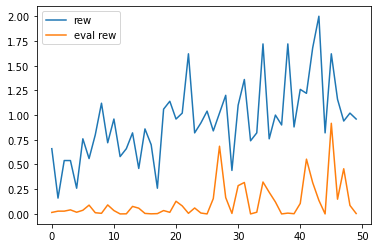

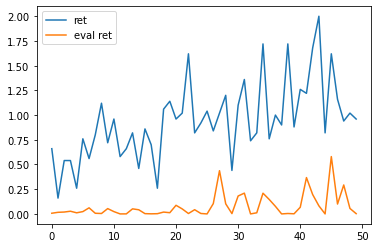

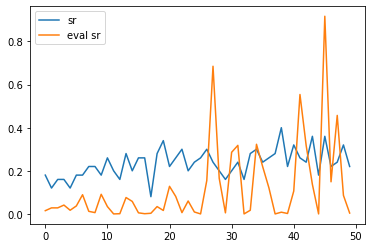

In [146]:
#(ep, 1rew, 2ret, 3st_r, 4su_r, 5eval_rew, 6eval_ret, 7eval_stay, 8eval_succ)

'''reward, eval reward'''
plt.plot(fetch_reach[:,:,1].mean(0),label = 'rew')
plt.plot(fetch_reach[:,:,5].mean(0),label='eval rew')
plt.legend()
plt.show()
'''return, eval return'''
plt.plot(fetch_reach[:,:,2].mean(0),label = 'ret')
plt.plot(fetch_reach[:,:,6].mean(0),label='eval ret')
plt.legend()
plt.show()
'''sr, eval_sr'''
plt.plot(fetch_reach[:,:,4].mean(0),label = 'sr')
plt.plot(fetch_reach[:,:,8].mean(0),label='eval sr')
plt.legend()
plt.show()


In [138]:
fetch_reach[:,:,1]

array([['0.0', '0.0', '0.0', '0.2', '0.0', '0.0', '1.2', '0.6', '0.0',
        '1.4', '0.4', '0.2', '0.8', '3.6', '0.2', '0.8', '2.4', '0.0',
        '3.6', '0.8', '1.8', '0.0', '6.2', '1.0', '0.2', '1.0', '0.4',
        '0.0', '0.4', '0.0', '0.0', '3.2', '0.8', '0.2', '2.4', '1.0',
        '0.0', '0.2', '2.0', '0.4', '1.8', '0.4', '3.0', '1.8', '0.0',
        '2.4', '1.4', '1.4', '0.6', '0.2'],
       ['0.6', '0.0', '0.8', '0.4', '0.0', '0.4', '1.0', '0.2', '0.6',
        '0.4', '1.8', '0.0', '1.0', '0.6', '0.0', '0.4', '0.0', '0.2',
        '0.0', '0.0', '0.0', '0.2', '0.0', '0.0', '0.0', '0.2', '0.0',
        '0.0', '0.0', '0.0', '0.0', '0.0', '0.6', '0.6', '1.0', '0.0',
        '0.4', '2.0', '0.0', '0.0', '0.0', '0.8', '0.0', '1.8', '0.0',
        '1.0', '0.4', '0.0', '0.4', '1.0'],
       ['2.6', '0.2', '0.8', '2.6', '0.0', '1.2', '0.0', '1.4', '0.6',
        '0.8', '0.6', '0.6', '0.0', '0.6', '1.0', '0.0', '0.0', '0.0',
        '0.8', '1.0', '1.0', '0.0', '0.6', '0.0', '0.0', '0.

In [81]:
reacher = []
fetch_reach = []
fetch_reach_eval = []
sawyerxyz = []
pointlarge = []
point2d = []
sawyer = []
for i in range(10):
    fetch_reach_eval.append(np.load(f'Result_PPO/evaluation_result_envFetchReach-v1_repeat{i}.npy'))
    fetch_reach.append(np.load(f'Result_PPO/envFetchReach-v1_repeat{i}.npy'))

In [82]:
np.shape(fetch_reach[0])

(2, 250)

In [83]:
fetch_reach[0]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         2.        ,  3.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  3.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         5.        ,  0.        ,  0.        ,  0.        ,  2.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  2.        ,  0.        ,  2.        ,  0.        ,
         1.        ,  0.        ,  2.        , 13. 

In [147]:
!python3 ppo_train_baseline.py -en FetchReach-v1

Traceback (most recent call last):
  File "ppo_train_baseline.py", line 41, in <module>
    torch.cuda.set_device(argss.gpu)
  File "/home/hsun/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/cuda/__init__.py", line 290, in set_device
    device = _get_device_index(device)
  File "/home/hsun/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/cuda/_utils.py", line 34, in _get_device_index
    'or an integer, but got: '.format(device))
ValueError: Expected a cuda device with a specified index or an integer, but got: 
